In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

block_plot = False

# Fix seeds for reproducibility.
SEED_VALUE = 29
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [2]:
# System Configuration
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


In [3]:
# Read data
def get_data():

    mnist_data = tf.keras.datasets.mnist

    # Load dataset.
    (X_train_in, y_train_in), (X_test_in, y_test_in) = mnist_data.load_data()

    return (X_train_in, y_train_in), (X_test_in, y_test_in)

In [4]:
# Data preproccessing
def preprocess_dataset(train_set, test_set, resize_to=None, num_classes=10, seed=3):

    (X_train, y_train) = train_set
    (X_test, y_test) = test_set

    # Split training data into train and validation.
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                          y_train,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          test_size=0.1,
                                                          random_state=seed,
                                                         )

    # Add axis to gray scale.
    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_valid = tf.expand_dims(X_valid, axis=3)
        X_test  = tf.expand_dims(X_test,  axis=3)

    # MNIST model image size is 28x28 but LeNet expects 32x32
    # Resize images if requested.
    if resize_to:
        if isinstance(resize_to, int):
            resize_to = (resize_to, resize_to)
        X_train = tf.image.resize(X_train, resize_to)
        X_valid = tf.image.resize(X_valid, resize_to)
        X_test  = tf.image.resize(X_test,  resize_to)

    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]
    n_test  = X_test.shape[0]

    image_shape = X_train[0].shape
    print('\n')
    print('There are {} training examples'.format(n_train))
    print('There are {} validation examples'.format(n_valid))
    print('There are {} test examples'.format(n_test))
    print('Image data shape is {}'.format(image_shape))

    # Confirm number of classes present in the dataset matches the specified number of classes.
    assert num_classes == len(
        np.unique(y_train)
    ), "Number of classes present in the dataset does not match specified nuber of classes."

    print('There are {} classes'.format(num_classes))

    NUM_CLASSES = num_classes

    # One-hot encode labels if necessary.
    if len(y_train.shape) != 2:
        y_train = tf.one_hot(y_train, NUM_CLASSES)
        y_valid = tf.one_hot(y_valid, NUM_CLASSES)
        y_test  = tf.one_hot(y_test,  NUM_CLASSES)

    print('\nData split:\n')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_valid: {X_valid.shape}, y_valid: {y_valid.shape}')
    print(f'X_test:  {X_test.shape},  y_test:  {y_test.shape}')

    # Normalize pixel values to the range: [0. - 1.0].
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0
    X_test  = X_test  / 255.0

    print("\nGround truth labels have been one-hot encoded: \n")
    print(np.transpose(y_train[:9]))

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [5]:
# Data Visualization
def visualize_samples(X, y):

    plt.figure(figsize=(18, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap='gray')
        plt.xlabel(y[i])
        plt.axis("off")

    plt.suptitle('Dataset Samples', fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    plt.close()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


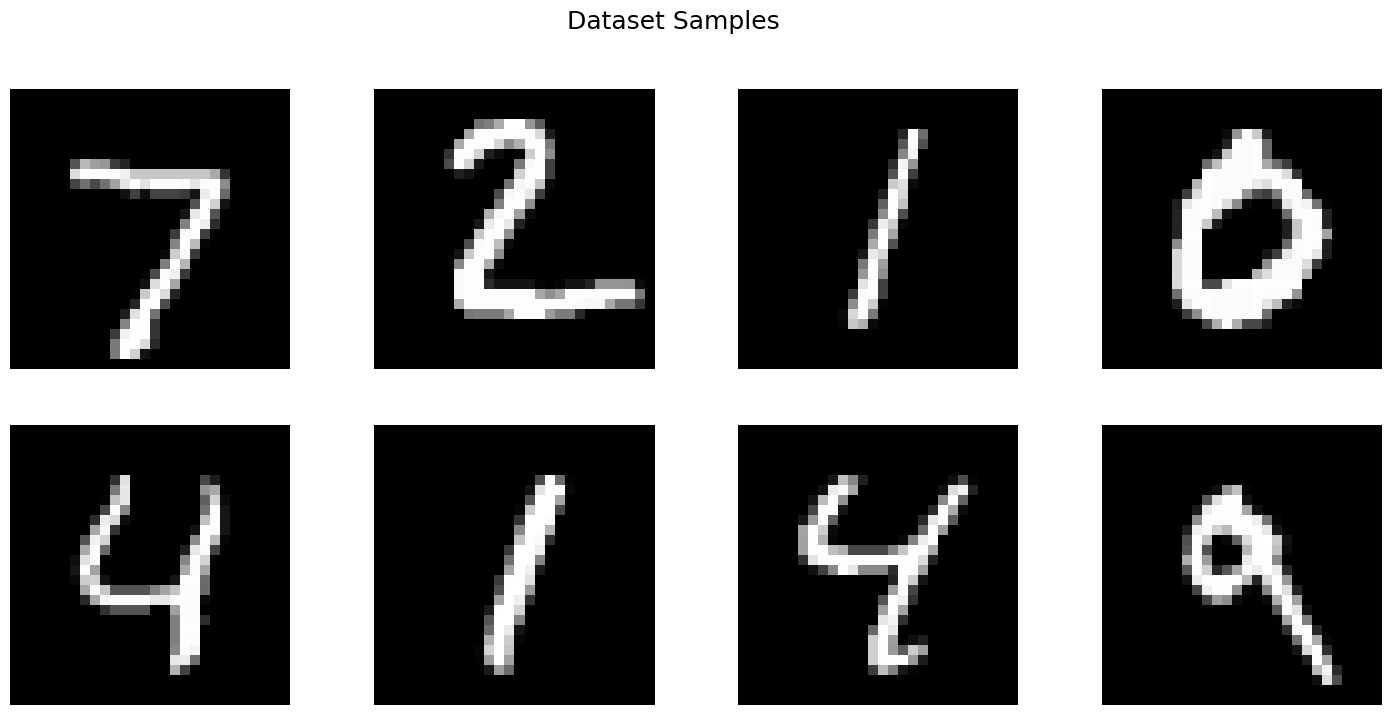

In [6]:
# Download the MNIST dataset.
(X_train_in, y_train_in), (X_test_in, y_test_in) = get_data()

visualize_samples(X_test_in, y_test_in)

In [7]:
# Preprocess the dataset
@dataclass(frozen=True)
class DatasetConfig:
    IMG_HEIGHT:  int = 32
    IMG_WIDTH:   int = 32
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 21
    LEARNING_RATE:  float = 0.01

data_config = DatasetConfig()
training_config = TrainingConfig()

# Preprocess the dataset.
((X_train, y_train),
 (X_valid, y_valid),
 (X_test,  y_test)) = preprocess_dataset((X_train_in, y_train_in),
                                        (X_test_in, y_test_in),
                                        resize_to=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH),
                                        num_classes=data_config.NUM_CLASSES,
                                        )



There are 54000 training examples
There are 6000 validation examples
There are 10000 test examples
Image data shape is (32, 32, 1)
There are 10 classes

Data split:

X_train: (54000, 32, 32, 1), y_train: (54000, 10)
X_valid: (6000, 32, 32, 1), y_valid: (6000, 10)
X_test:  (10000, 32, 32, 1),  y_test:  (10000, 10)

Ground truth labels have been one-hot encoded: 

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


In [8]:
# Modeling the LeNet5 Architecture

In [9]:
# using Keras function API
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, Input, MaxPool2D

In [10]:
def LeNet5_model(input_shape=(32, 32, 1), num_classes=10, print_summary=True):

    inputs = Input(shape=input_shape)

    # BODY (Feature Extractor)
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # HEAD
    # -------------------------
    # Fully conneted layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84

    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10

    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')

    if print_summary:
        model.summary()

    return model

In [11]:
# Training pipleline
def train_model(train_set, print_model_summary=False):

    (X_train, y_train) = train_set

    # Initialize the LeNet Model.
    model = LeNet5_model(input_shape=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH,data_config.CHANNELS,),
                         num_classes=data_config.NUM_CLASSES,
                         print_summary=print_model_summary,
                        )

    # Initialize the LeNet Model (using the Sequentail API)
    #model = LeNet5_model_seq(input_shape=(data_config.IMG_HEIGHT, data_config.IMG_WIDTH,data_config.CHANNELS,),
    #                    num_classes=data_config.NUM_CLASSES,
    #                    print_summary=print_model_summary,)


    # Compile the model.
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=training_config.LEARNING_RATE),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"],
                 )

    print("\n\n")
    # Train the model.
    results = model.fit(X_train,
                        y_train,
                        epochs=training_config.EPOCHS,
                        batch_size=training_config.BATCH_SIZE,
                        validation_data=(X_valid, y_valid),
                       )

    return model, results

In [12]:
# Training execution
# Start Training.
model, training_results = train_model(train_set=(X_train, y_train), print_model_summary=True)

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)




Epoch 1/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.6044 - loss: 1.2078 - val_accuracy: 0.9503 - val_loss: 0.1608
Epoch 2/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9522 - loss: 0.1561 - val_accuracy: 0.9672 - val_loss: 0.1056
Epoch 3/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.9673 - loss: 0.1075 - val_accuracy: 0.9728 - val_loss: 0.0868
Epoch 4/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.9745 - loss: 0.0855 - val_accuracy: 0.9778 - val_loss: 0.0736
Epoch 5/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.9781 - loss: 0.0722 - val_accuracy: 0.9790 - val_loss: 0.0671
Epoch 6/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.9810 - loss: 0.0627 - val_accuracy: 0.9803 - val_loss: 0.0620
Epoch 7/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9829 - loss: 0.0554 - val_accuracy: 0.9803 - val_loss: 0.0590
Epoch 8/21
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.984

In [13]:
# Plot training results
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


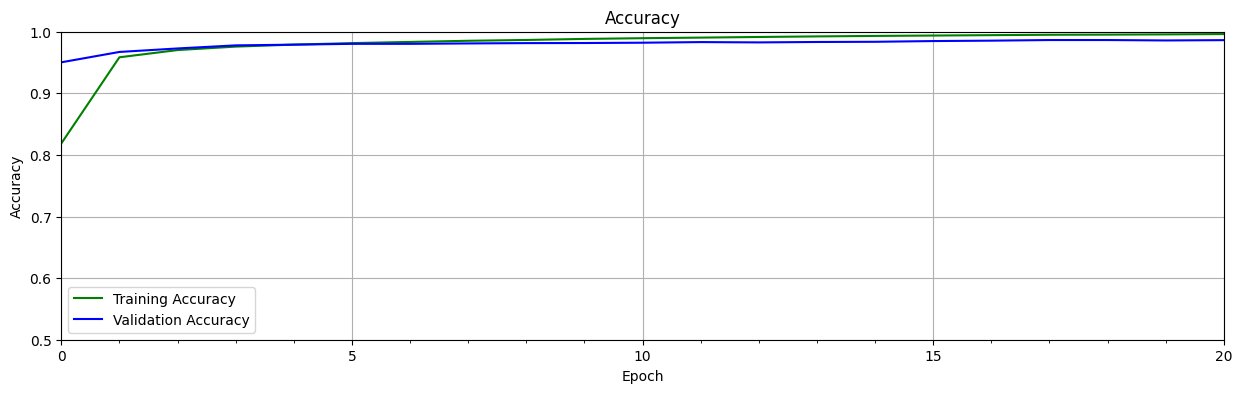

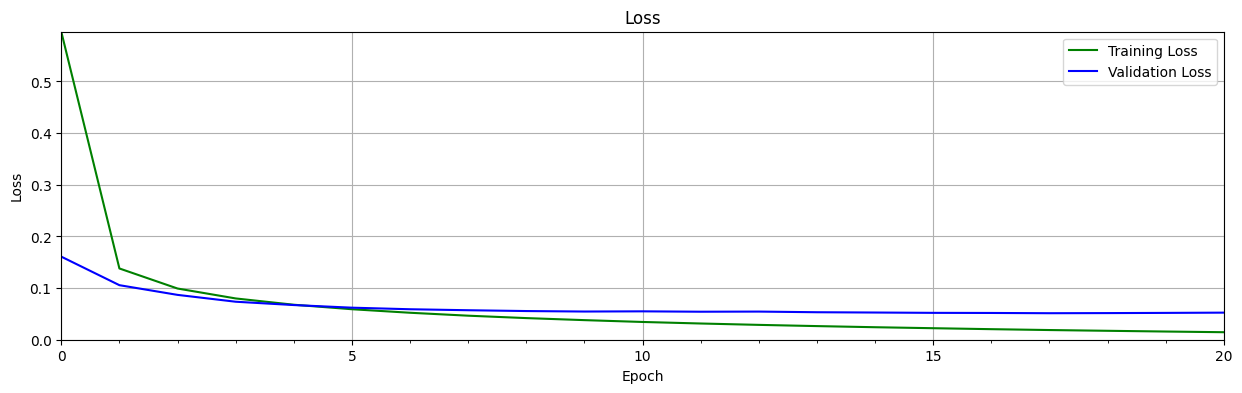

In [14]:
# Print history dictionary keys.
print(training_results.history.keys())

# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [15]:
# Model evaluation
def evaluate_model(model, *test_set):

    X_test, y_test = test_set

    # Evaluate model performance on the test set.
    test_results = model.evaluate(X_test, y_test)

    # Select 20 random points from the test set for display.
    random.seed(SEED_VALUE)
    num_rows = 4
    num_cols = 5
    num_data = num_rows*num_cols
    shuffled_index = random.sample(range(y_test.shape[0]), num_data)

    X_sampled = tf.gather(X_test, shuffled_index)
    y_sampled = tf.gather(y_test, shuffled_index)

    # Generate predictions on the sampled test set.
    y_pred_sampled = model.predict(X_sampled)

    num_matches = 0

    # Plot the test images and predicted labels.
    plt.figure(figsize=(18, 12))
    for i in range(num_data):
        plt.subplot(num_rows, num_cols, i + 1)
        pred = np.argmax(y_pred_sampled[i])
        truth = np.argmax(y_sampled[i])
        title = 'True: ' + str(truth) + '; Pred: ' + str(pred)
        title_obj = plt.title(title, fontdict={'fontsize':16})

        if pred == truth:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
        plt.axis("off")
        plt.imshow(X_sampled[i].numpy().squeeze(), cmap="gray")

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)

    return test_results

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9828 - loss: 0.0600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


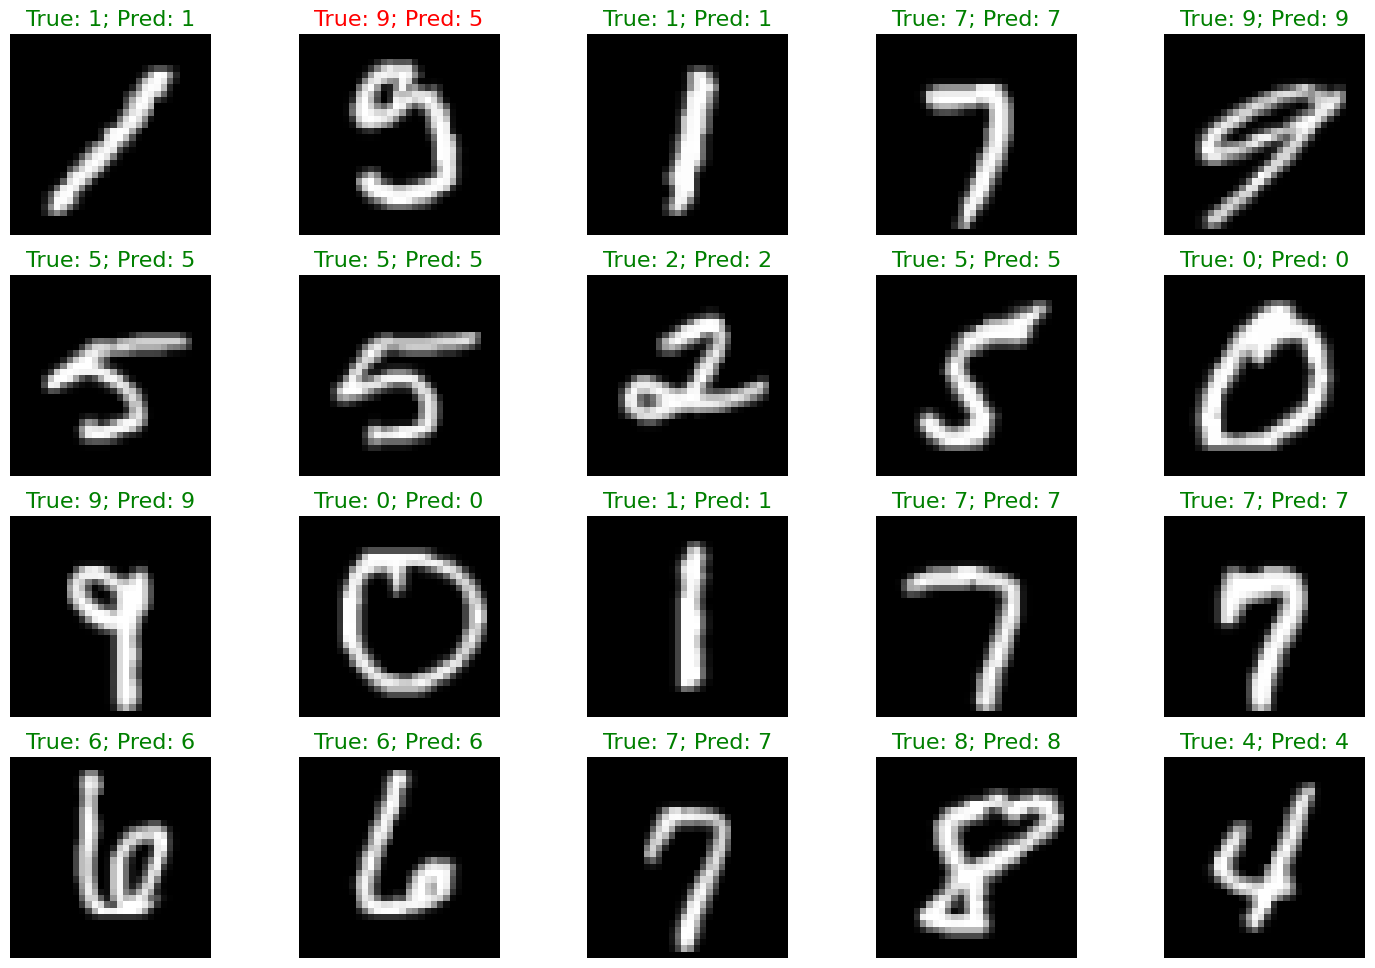

In [16]:
test_set = (X_test, y_test)
test_results = evaluate_model(model, *test_set)